Import libraries

In [1]:
# you need to install pykeen beforehand, see https://pykeen.readthedocs.io/en/stable/installation.html 
import os
import numpy as np
import pandas as pd
import pykeen
import seaborn

# 1. Dataset exploration


PyKeen comes with its own datasets that can be used directly in a pipeline.
Below we import it so that we can explore it later.

In [2]:
from pykeen.datasets import Nations

/Users/arina/.pyenv/versions/3.10.13/envs/krwvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


However, we want to be able tfo work with our own datasets as well, so we etch the online GoT dataset as well.

In [3]:
import requests
from pykeen import triples

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/GoT.csv'
open('GoT.csv', 'wb').write(requests.get(url).content)

# Format that can be read by a pd.from_csv should also be able to be read here, but the delimiter needs to be adjusted
# PyKEEN uses tabs as defaults
got = triples.TriplesFactory.from_path('GoT.csv', load_triples_kwargs=dict(delimiter=','))
got_triples = got.triples
got_triples[:5,]

Reconstructing all label-based triples. This is expensive and rarely needed.


array([['Abelar Hightower', 'ALLIED_WITH',
        'House Hightower of the Hightower'],
       ['Acorn Hall', 'SEAT_OF', 'House Smallwood of Acorn Hall'],
       ['Addam Frey', 'ALLIED_WITH', 'House Frey of the Crossing'],
       ['Addam Marbrand', 'ALLIED_WITH', 'House Marbrand of Ashemark'],
       ['Addam Osgrey', 'ALLIED_WITH', 'House Osgrey of Standfast']],
      dtype='<U44')

### Exercise 1

List the unique subject and object entities found in the dataset. Then list all of the relationships that link the entities (note that some entities are not linked). Create an RDF version of the dataset, using your own namespaces, and save is as a ttl file. 

Using SPARQL, answer the following questions : 
1. How many instances per class? Use ORDER BY to show the most popular class
2. What is the most common relation per each class?

In [4]:
df = pd.DataFrame(got_triples)
subjects = df.iloc[:, 0]
properties = df.iloc[:, 1]
objects = df.iloc[:, 2]

In [5]:
df

,0,1,2
0,Abelar Hightower,ALLIED_WITH,House Hightower of the Hightower
1,Acorn Hall,SEAT_OF,House Smallwood of Acorn Hall
2,Addam Frey,ALLIED_WITH,House Frey of the Crossing
3,Addam Marbrand,ALLIED_WITH,House Marbrand of Ashemark
4,Addam Osgrey,ALLIED_WITH,House Osgrey of Standfast
...,...,...,...
3170,formerly Whitewalls,SEAT_OF,House Butterwell
3171,northern mountains,SEAT_OF,House Flint of the mountains
3172,the Antlers,SEAT_OF,House Buckwell of the Antlers
3173,the Paps,SEAT_OF,House Elesham of the Paps


In [6]:
print(f"{len(subjects.unique())} subjects:\n{subjects.unique()}")
print(f"{len(properties.unique())} properties:\n{properties.unique()}")
print(f"{len(objects.unique())} objects:\n{objects.unique()[:5]}")

2006 subjects:
['Abelar Hightower' 'Acorn Hall' 'Addam Frey' ... 'the Antlers' 'the Paps'
 'unnamed tower']
10 properties:
['ALLIED_WITH' 'SEAT_OF' 'PARENT_OF' 'SPOUSE' 'HEIR_TO' 'IN_REGION'
 'SWORN_TO' 'LED_BY' 'BRANCH_OF' 'FOUNDED_BY']
745 objects:
['House Hightower of the Hightower' 'House Smallwood of Acorn Hall'
 'House Frey of the Crossing' 'House Marbrand of Ashemark'
 'House Osgrey of Standfast']


In [7]:
from rdflib import Graph, RDFS, RDF, URIRef, Namespace, Literal

urisubjects = [URIRef(f"http://example.org/got/{i.replace(' ', '_')}") for i in subjects]
uriproperties = [URIRef(f"http://example.org/got/{i.replace(' ', '_')}") for i in properties]
uriobjects = [URIRef(f"http://example.org/got/{i.replace(' ', '_')}") for i in objects]

In [8]:
graph = Graph()
GOT = Namespace("http://example.org/got/")

In [9]:
for s, p, o in zip(urisubjects, uriproperties, uriobjects):
    graph.add((s, p, o))

In [10]:
graph.serialize(destination="data/got.ttl") 

<Graph identifier=N5a4369f8cba74c5e8488072791371386 (<class 'rdflib.graph.Graph'>)>

In [11]:
count = 0
for s, p, o in graph.triples((None, None, None)):
    count += 1
print(count)

3175


In [57]:
q1 = graph.query("""select ?subj (count(?subj) AS ?count) where {?subj ?pred ?obj}
                 group by ?subj order by desc(?count)""", initNs={'ns1': 'http://example.org/got/' })
for i in list(q1)[:5]:
    print(f"{i}\n")

(rdflib.term.URIRef('http://example.org/got/Walder_Frey'), rdflib.term.Literal('10', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/Harrenhal'), rdflib.term.Literal('7', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/Alyssa_Velaryon'), rdflib.term.Literal('6', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/Rohanne_Webber'), rdflib.term.Literal('6', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/House_Frey_of_Riverrun'), rdflib.term.Literal('5', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))



In [13]:
q2 = graph.query("""select distinct ?pred (count(?pred) AS ?count) where { ?s ?pred ?obj}
                 group by ?pred order by desc(?count)""", initNs={'ns1': 'http://example.org/got/' })
for i in list(q2):
    print(f"{i}\n")

(rdflib.term.URIRef('http://example.org/got/ALLIED_WITH'), rdflib.term.Literal('1517', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/IN_REGION'), rdflib.term.Literal('437', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/SWORN_TO'), rdflib.term.Literal('397', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/SEAT_OF'), rdflib.term.Literal('243', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/SPOUSE'), rdflib.term.Literal('198', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/LED_BY'), rdflib.term.Literal('179', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')))

(rdflib.term.URIRef('http://example.org/got/PARENT_O

# 2. Defining train and test datasets


As is typical in machine learning, we need to split our dataset into training and test (and sometimes validation) datasets.

What differs from the standard method of randomly sampling N points to make up our test set, is that our data points are two entities linked by some relationship, and we need to take care to ensure that all entities are represented in train and test sets by at least one triple.

To accomplish this, PyKEEN provides the <b>pykeen.triples.TriplesFactory.split()</b> function, which defaults to an 80/20 split. It is also by default stratified, to ensure that the distribution of the test set corresponds to that of the training set. If you want to use early stopping, you will also need a validation set. The function takes a list of percentages as argument: if you want a 95/5 split you give it <b>[0.95,0.05]</b> as argument, if you want 90/5/5 (which would include a validation set as well) you give it <b>[0.9,0.05,0.05]</b> as argument and it will return 3 datasets.

For sake of example, we will create a small test size that includes only 5% of triples. 

In [14]:
# got_training, got_testing = got.split()
got_training, got_testing = got.split([0.95, 0.05], random_state=0)

print('Train set size: ', got_training.triples.shape)
print('Test set size: ', got_testing.triples.shape)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


Train set size:  (3016, 3)
Test set size:  (159, 3)


### Exercise 2

Create three train-test sets of different sizes from the GoT data. Give them different names. Make sure the test set is not too big when compared to the training set (test set should be max 15% of the total dataset).

In [15]:
got_training1, got_testing1 = got.split([0.88, 0.12], random_state=0)
print("1")
print('Train set size: ', got_training1.triples.shape)
print('Test set size: ', got_testing1.triples.shape)
got_training2, got_testing2 = got.split([0.9, 0.1], random_state=0)
print("2")
print('Train set size: ', got_training2.triples.shape)
print('Test set size: ', got_testing2.triples.shape)
got_training3, got_testing3 = got.split([0.92, 0.08], random_state=0)
print("3")
print('Train set size: ', got_training3.triples.shape)
print('Test set size: ', got_testing3.triples.shape)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


1
Train set size:  (2794, 3)
Test set size:  (381, 3)
2
Train set size:  (2857, 3)
Test set size:  (318, 3)
3
Train set size:  (2921, 3)
Test set size:  (254, 3)


# 3. Training and testing the model

PyKEEN has implemented several Knoweldge Graph Embedding models (TransE, ComplEx, DistMult, HolE, etc.). We will use the ComplEx model with default values for this tutorial.

You can find the list of all implemented models in the documentation: https://pykeen.readthedocs.io/en/stable/reference/models.html

Importing a model and instantiate it:
There are two ways to import and use a model, both are shown below and don't give different results but not importing the model before hand might cause the automatic importing to be slower, especially if you plan to use the same model multiple times.

No cuda devices were available. The model runs on CPU
Training batches on cpu:  83%|████████████▌  | 10/12 [00:00<00:00, 97.01batch/s]
Training epochs on cpu:  20%|▏| 1/5 [00:00<00:00,  4.36epoch/s, loss=17.2, prev_
Training batches on cpu:  92%|████████████▊ | 11/12 [00:00<00:00, 103.99batch/s]
Training epochs on cpu:  40%|▍| 2/5 [00:00<00:00,  4.59epoch/s, loss=16.8, prev_
Training batches on cpu:  92%|████████████▊ | 11/12 [00:00<00:00, 108.60batch/s]
Training epochs on cpu:  60%|▌| 3/5 [00:00<00:00,  4.73epoch/s, loss=15.9, prev_
Training batches on cpu:  92%|████████████▊ | 11/12 [00:00<00:00, 109.76batch/s]
Training epochs on cpu:  80%|▊| 4/5 [00:00<00:00,  4.85epoch/s, loss=15.4, prev_
Training batches on cpu:  92%|████████████▊ | 11/12 [00:00<00:00, 109.62batch/s]
Training epochs on cpu: 100%|█| 5/5 [00:01<00:00,  4.79epoch/s, loss=14.6, prev_
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batc

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

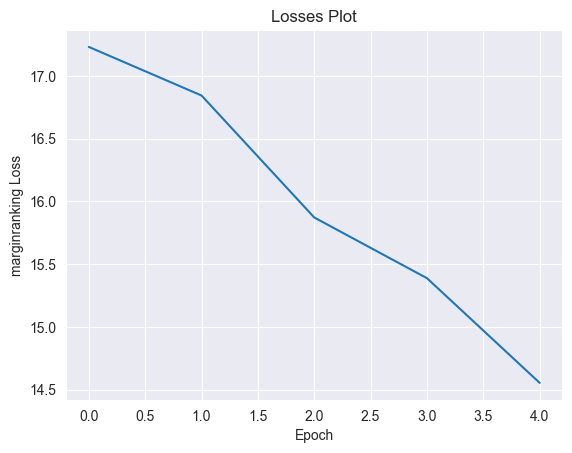

In [16]:
# wee need the pipeline to run a model, so it is simpler to import it directly.
# Pykeen lets you train a model with the minimal amount of custom parameters
from pykeen.pipeline import pipeline

# here we don't import the model, but let PyKEEN do the importing.
pipeline_result_simple = pipeline(
    random_seed=0,
    model='ComplEx',
    training=got_training,
    testing=got_testing,
)
pipeline_result_simple.plot_losses()

INFO:pykeen.pipeline.api:Using device: None
Training batches on cpu: 100%|██████████████| 12/12 [00:00<00:00, 110.79batch/s]
Training epochs on cpu:  20%|▏| 1/5 [00:00<00:00,  4.97epoch/s, loss=17.2, prev_
Training batches on cpu: 100%|██████████████| 12/12 [00:00<00:00, 113.74batch/s]
Training epochs on cpu:  40%|▍| 2/5 [00:00<00:00,  5.09epoch/s, loss=16.8, prev_
Training batches on cpu:  92%|████████████▊ | 11/12 [00:00<00:00, 105.92batch/s]
Training epochs on cpu:  60%|▌| 3/5 [00:00<00:00,  4.93epoch/s, loss=15.9, prev_
Training batches on cpu: 100%|██████████████| 12/12 [00:00<00:00, 114.16batch/s]
Training epochs on cpu:  80%|▊| 4/5 [00:00<00:00,  4.99epoch/s, loss=15.4, prev_
Training batches on cpu:  92%|████████████▊ | 11/12 [00:00<00:00, 107.35batch/s]
Training epochs on cpu: 100%|█| 5/5 [00:01<00:00,  4.95epoch/s, loss=14.6, prev_
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size wil

<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

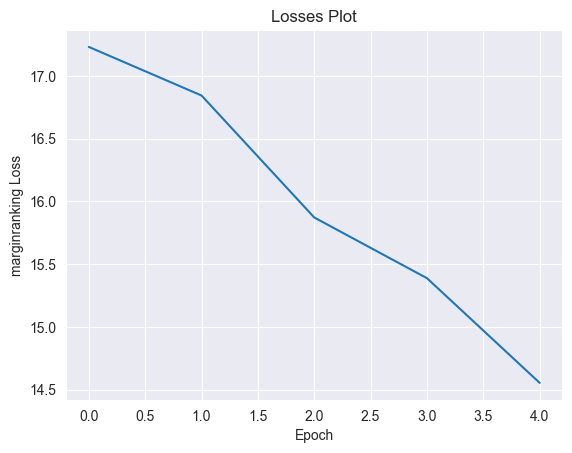

In [17]:
# here we import the model and use it directly.
from pykeen.models import ComplEx

pipeline_result_imported = pipeline(
    random_seed=0,
    model=ComplEx,
    training=got_training,
    testing=got_testing,
)
pipeline_result_imported.plot_losses()

You can retrieve different metrics from the results. Here we retrieve the mean reciprocal rank (MRR). The result is the same for both the simple and imported model, because we used the same random seed (0).

In [18]:
print(pipeline_result_imported.get_metric('mrr'))
print(pipeline_result_simple.get_metric('mrr'))

0.002994442824274301
0.002994442824274301


In [ ]:
# but to get a better performing model, you want to set different things
pipeline_result = pipeline(
    random_seed=0,
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    epochs=200,
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
)

In [20]:
print(pipeline_result.get_metric('mrr'))

0.0042846654541790485


Understanding the parameters:

- dimensions : the dimensionality of the embedding space
- negative_sampler : the negative samplic strategy, here set to default (not used in arguments).
- batch_size : the number of batches in which the training set is split during the training loop. If you are having into low memory issues than settings this to a higher number may help.
- epochs : the number of epochs to train the model for.
- optimizer : the Adam optimizer, with a learning rate of $1e-3$ set via the <i>optimizer_kwarg</i>.
- loss : pairwise loss, with a margin of $0.5$ set via the <i>loss_kwarg</i>.
- regularizer :  regularization with $p=2$, i.e. $l_2$ regularization. $\lambda$ = $1e-5$, set via the <i>regularizer_kwarg</i>.

### Filtering Negatives

To ensure our model can be trained and evaluated correctly, we need to define a filter to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply done by concatenating train and test sets. When negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

With PyKEEN this is made very easy, and can simply be passed as an argument.

In [ ]:
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    epochs=200,
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
    
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
    )
)

In [22]:
print(pipeline_result.get_metric('mrr'))

0.004578010179102421


To save your learned model and also the results, we need to add checkpoints to the pipeline.
By adding training kwargs to the pipeline, the model will be automatically saved. By default, it saves the model after every epoch (checkpoint_frequency=0). You can also set the directory to which the models are saved, but by default they will end up in ~/.data/pykeen/checkpoints.

In [ ]:
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    training_kwargs=dict(
        num_epochs=200,
        checkpoint_name='got_complex_checkpoint.pt',
        checkpoint_directory='checkpoint_dir/',
        checkpoint_frequency=20,
    ),
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
    )
)

There is another way to save models, but for that we need to do the training and evaluating outside of the pipeline model. Below is an example of the above model training outside of the pipeline module.

In [ ]:
from pykeen.models import ComplEx
model = ComplEx(triples_factory=got_training)

from pykeen.optimizers import Adam
optimizer = Adam(params=model.get_grad_params())

# from pykeen.regularizers import LP
# regularizer = LP(p=3,weight=1e-5)

from pykeen.training import SLCWATrainingLoop
training_loop = SLCWATrainingLoop(model=model,
                                  triples_factory=got_training,
                                  optimizer=optimizer)

#training
_ = training_loop.train(triples_factory=got_training,
                    num_epochs=200)

#evaluating
from pykeen.evaluation import RankBasedEvaluator
evaluator = RankBasedEvaluator()
mapped_triples = got_testing.mapped_triples

results = evaluator.evaluate(
            model=model,
            mapped_triples=mapped_triples,
            )

print(results.get_metric('mrr'))

#save results, this works also with the pipeline results, as the results object 
#returned by the evaluator is the same as the one returned from the pipeline
save_dir = 'got_complex'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
results.to_df().to_csv(save_dir+os.path.sep+'results.csv')

models_dir = 'models'
if not os.path.isdir(models_dir):
    os.mkdir(models_dir)

import torch
torch.save(model,'models/trained_model.pkl')

#to load the model use the following command
# my_pykeen_model = torch.load('models/trained_model.pkl')

### Exercise 3

Try changing the parameters of your training process. See if you obtain a better model in terms of average loss. Save it as ./data/best_model.pkl. Which parameters work best for the dataset? 

Now use the training and test set you created in Exercise 2. Which loss you obtain, and for which parameters? 

Remember to save each model locally with a different name, so you can find them back.

In [25]:
# for simplicity, we are trying to change the number of epochs only
def find_parameters(training, testing, csv_name, pkl_name):
    epochs = [200, 100, 150, 250, 300]
    mrrs = []
    best_epochs = 200
    best_mrr = 0
    for current_epochs in epochs:
        model = ComplEx(triples_factory=training, random_seed=0)
        optimizer = Adam(params=model.get_grad_params())
        training_loop = SLCWATrainingLoop(model=model,
                                          triples_factory=training,
                                          optimizer=optimizer)
        _ = training_loop.train(triples_factory=training, num_epochs=current_epochs)
        evaluator = RankBasedEvaluator()
        mapped_triples = testing.mapped_triples
        results = evaluator.evaluate(
                    model=model,
                    mapped_triples=mapped_triples,)
        
        current_mrr = results.get_metric('mrr')
        mrrs.append(current_mrr)
        print(current_mrr)
    
        if current_mrr > best_mrr:
            best_epochs = current_epochs
            best_mrr = current_mrr
            results.to_df().to_csv(csv_name)
            torch.save(model, pkl_name)
    return mrrs, best_epochs, best_mrr

In [ ]:
mrrs, best_epochs, best_mrr = find_parameters(got_training, got_testing,
                                              'data/best_model_results.csv', 'models/best_model.pkl')

In [ ]:
mrrs1, best_epochs1, best_mrr1 = find_parameters(got_training1, got_testing1,
                                                 'data/best_model_results1.csv', 'models/best_model1.pkl')

In [ ]:
mrrs2, best_epochs2, best_mrr2 = find_parameters(got_training2, got_testing2,
                                                 'data/best_model_results2.csv', 'models/best_model2.pkl')

In [ ]:
mrrs3, best_epochs3, best_mrr3 = find_parameters(got_training3, got_testing3,
                                                'data/best_model_results3.csv', 'models/best_model3.pkl')

In [30]:
print(f"Best number of epochs: {best_epochs}\nBest mmr: {best_mrr}")

Best number of epochs: 100
Best mmr: 0.00330454227514565


In [31]:
print("1")
print(f"Best number of epochs: {best_epochs1}\nBest mmr: {best_mrr1}")

1
Best number of epochs: 100
Best mmr: 0.0036525933537632227


In [32]:
print("2")
print(f"Best number of epochs: {best_epochs2}\nBest mmr: {best_mrr2}")

2
Best number of epochs: 250
Best mmr: 0.0034179675858467817


In [33]:
print("3")
print(f"Best number of epochs: {best_epochs3}\nBest mmr: {best_mrr3}")

3
Best number of epochs: 100
Best mmr: 0.0028978066984564066


# 4. Evaluating the Model

### Metrics

We can now get some evaluation metrics for our model, they were already computed during evaluation time as part of the pipeline, and print them out.

We are going to use the following evaluation metrics:
- <i>mrr</i> (mean reciprocal rank) : this function computes the mean of the reciprocal of elements of a vector of rankings ranks
- <i>hits_at_n</i> : this function computes how many elements of a vector of rankings ranks make it to the $top_n$ positions.

NB : The choice of which _N_ makes more sense depends on the application and the size of the dataset.

In [34]:
pipeline_result.get_metric('hits_at_10')

0.006289308176100629

In [35]:
# from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = pipeline_result.get_metric('mrr')
print("MRR: %.4f" % (mrr))
print()

hits_10 = pipeline_result.get_metric('hits_at_10')
print("Hits@10: %.6f" % (hits_10))
print("Interpretation: on average, the model guessed the correct subject or object %.1f%% of the time when considering the top-10 better ranked triples.\n" % (hits_10*100))

hits_3 = pipeline_result.get_metric('hits_at_3')
print("Hits@3: %.6f" % (hits_3))
print("Interpretation: on average, the model guessed the correct subject or object %.1f%% of the time when considering the top-3 better ranked triples.\n" % (hits_3*100))

# hits_1 = hits_at_n_score(ranks, n=1)
# print("Hits@1: %.2f" % (hits_1))
# print("Interpretation: on average, the model guessed the correct subject or object %.1f%% of the time when considering the top-1 better ranked triples.\n" % (hits_1*100))

MRR: 0.0036

Hits@10: 0.006289
Interpretation: on average, the model guessed the correct subject or object 0.6% of the time when considering the top-10 better ranked triples.

Hits@3: 0.000000
Interpretation: on average, the model guessed the correct subject or object 0.0% of the time when considering the top-3 better ranked triples.



### Exercise 4

Evaluate the models you created before (different set sizes, different parameters). Summarise your results in a table.

In [ ]:
model = torch.load('models/best_model.pkl')
mapped_triples = got_testing.mapped_triples
results = evaluator.evaluate(model=model, mapped_triples=mapped_triples)

model1 = torch.load('models/best_model1.pkl')
mapped_triples1 = got_testing1.mapped_triples
results1 = evaluator.evaluate(model=model1, mapped_triples=mapped_triples1)

model2 = torch.load('models/best_model2.pkl')
mapped_triples2 = got_testing2.mapped_triples
results2 = evaluator.evaluate(model=model2, mapped_triples=mapped_triples2)

model3 = torch.load('models/best_model3.pkl')
mapped_triples3 = got_testing3.mapped_triples
results3 = evaluator.evaluate(model=model3, mapped_triples=mapped_triples3)

In [37]:
test_size = [0.05, 0.12, 0.1, 0.08]
n_epochs = [best_epochs, best_epochs1, best_epochs2, best_epochs3]
mrr = [best_mrr, best_mrr1, best_mrr2, best_mrr3]
hits_10 = [results.get_metric('hits_at_10'), results1.get_metric('hits_at_10'),
           results2.get_metric('hits_at_10'), results3.get_metric('hits_at_10')]
hits_3 = [results.get_metric('hits_at_3'), results1.get_metric('hits_at_3'),
          results2.get_metric('hits_at_3'), results3.get_metric('hits_at_3')]

In [38]:
data = {'Test Size': test_size, 'Number of Epochs': n_epochs,
        'MRR': mrr, 'Hits@10': hits_10, 'Hits@3': hits_3}
comparison = pd.DataFrame(data)
comparison

,Test Size,Number of Epochs,MRR,Hits@10,Hits@3
0,0.05,100,0.003305,0.003145,0.0
1,0.12,100,0.003653,0.003937,0.0
2,0.10,250,0.003418,0.003145,0.0
3,0.08,100,0.002898,0.003937,0.0


# 5. Link Prediction

Link prediction allows to infer missing links in a graph. This has many real-world use cases, such as predicting connections between people in a social network, interactions between proteins in a biological network, and music recommendation based on prior user taste.

In our case, we are going to see which of the following candidate statements is more likely to be true. Note that the candidate statements below are made up, i.e. they are not in the original dataset.

In [39]:
X_unseen = np.array([
    ['Jorah Mormont', 'SPOUSE', 'Daenerys Targaryen'],
    ['Tyrion Lannister', 'SPOUSE', 'Missandei'],
    ["King's Landing", 'SEAT_OF', 'House Lannister of Casterly Rock'],
    ['Sansa Stark', 'SPOUSE', 'Petyr Baelish'],
    ['Daenerys Targaryen', 'SPOUSE', 'Jon Snow'],
    ['Daenerys Targaryen', 'SPOUSE', 'Craster'],
    ['House Stark of Winterfell', 'IN_REGION', 'The North'],
    ['House Stark of Winterfell', 'IN_REGION', 'Dorne'],
    ['House Tyrell of Highgarden', 'IN_REGION', 'Beyond the Wall'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],    
    ['Rhaegar Targaryen', 'PARENT_OF', 'Jon Snow'],
    ['House Hutcheson', 'SWORN_TO', 'House Tyrell of Highgarden'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],
    ['Jaime Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Robert I Baratheon', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Brandon Stark'],
    ["Tywin Lannister", 'PARENT_OF', 'Jaime Lannister'],
    ["Missandei", 'SPOUSE', 'Grey Worm'],
    ["Brienne of Tarth", 'SPOUSE', 'Jaime Lannister']
])

## we need to map the above triples to the id's which we used in our training/testing.
## This information is stored in the triple factory "got", which we created at the beginning

# unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))
#     filter_triples=unseen_filter,   # Corruption strategy filter defined above 
#     corrupt_side = 's+o',
#     use_default_protocol=False, # corrupt subj and obj separately while evaluating
#     verbose=True
# )


In [40]:
from pykeen import predict
# from pykeen.predict import predict_triples

# got_unseen = triples.get_mapped_tripples(X_unseen,factory=got)
pack = predict.predict_triples(model=pipeline_result.model, triples=X_unseen, triples_factory=got)

In [41]:
# scores are real numbers that need to be translated into probabilities [0,1] 
# for this, we use the expit transform.

from scipy.special import expit
processed_results = pack.process().df
# print(processed_results)

probs = expit(processed_results['score'])
# print(probs)

processed_results['prob'] = probs
processed_results['triple'] = list(zip([' '.join(x) for x in X_unseen]))

# processed_results
pred_df = pd.DataFrame(list(zip([' '.join(x) for x in X_unseen],  
                      round(np.squeeze(processed_results['score']), 4),
                      round(np.squeeze(probs), 4))), 
             columns=['statement', 'score', 'prob']).sort_values("score")

NB : the probabilities are not calibrated in any sense. To calibrate them, one may use a procedure such as [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) or [Isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression). The challenge is to define what is a true triple and what is a false one, as the calibration of the probability of a triple being true depends on the base rate of positives and negatives.

### Exercise 5

Analyse the results in the tables. Some predicted links are very likely to be true, others  capture things that never really happened. Can you spot which ones?

In [42]:
pred_df

,statement,score,prob
19,Tywin Lannister PARENT_OF Jaime Lannister,-41.236599,0.0000
2,King's Landing SEAT_OF House Lannister of Cast...,-39.513100,0.0000
6,House Stark of Winterfell IN_REGION The North,-36.525902,0.0000
7,House Stark of Winterfell IN_REGION Dorne,-34.308800,0.0000
15,Jaime Lannister PARENT_OF Myrcella Baratheon,-14.285300,0.0000
12,House Hutcheson SWORN_TO House Tyrell of Highg...,-11.242600,0.0000
5,Daenerys Targaryen SPOUSE Craster,-5.611800,0.0036
4,Daenerys Targaryen SPOUSE Jon Snow,-4.161900,0.0153
14,Daenerys Targaryen ALLIED_WITH House Lannister...,-3.378600,0.0330
17,Cersei Lannister PARENT_OF Myrcella Baratheon,-0.525900,0.3715


In [43]:
print("Links are very likely to be true:")
list(pred_df[pred_df["prob"] >= 0.99]["statement"])

Links are very likely to be true:


['Cersei Lannister PARENT_OF Brandon Stark',
 'Robert I Baratheon PARENT_OF Myrcella Baratheon',
 'Brienne of Tarth SPOUSE Jaime Lannister',
 'Rhaegar Targaryen PARENT_OF Jon Snow',
 'Jorah Mormont SPOUSE Daenerys Targaryen',
 'Daenerys Targaryen ALLIED_WITH House Stark of Winterfell',
 'Missandei SPOUSE Grey Worm',
 'Brandon Stark ALLIED_WITH House Lannister of Casterly Rock',
 'Tyrion Lannister SPOUSE Missandei',
 'Sansa Stark SPOUSE Petyr Baelish',
 'Brandon Stark ALLIED_WITH House Stark of Winterfell']

In [44]:
print("Things that never really happened:")
list(pred_df[pred_df["prob"] <= 0.01]["statement"])

Things that never really happened:


['Tywin Lannister PARENT_OF Jaime Lannister',
 "King's Landing SEAT_OF House Lannister of Casterly Rock",
 'House Stark of Winterfell IN_REGION The North',
 'House Stark of Winterfell IN_REGION Dorne',
 'Jaime Lannister PARENT_OF Myrcella Baratheon',
 'House Hutcheson SWORN_TO House Tyrell of Highgarden',
 'Daenerys Targaryen SPOUSE Craster']

# 6 Visualisation

[Tensorboard](https://www.tensorflow.org/tensorboard) allows to dig into the workings of our model, plot how it is learning, and visualize [high-dimensional embeddings](https://projector.tensorflow.org/). See [this tutorial](https://www.tensorflow.org/tensorboard/get_started) to get started with Tensorflow and see [here](https://pykeen.readthedocs.io/en/stable/tutorial/trackers/using_tensorboard.html) for Tensorboard with PyKEEN.

First you neeed to start the tensorboard web application from the command line with 

$ tensorboard --logdir=~/.data/pykeen/logs/tensorboard/

and then we can add tensorboard as the result_tracker in our pipeline.

In [45]:
# pip install tensorboard

In [ ]:
pipeline_result = pipeline(
    model='ComplEx',
    training=got_training,
    testing=got_testing,
    training_kwargs=dict(
        num_epochs=200
    ),
    dimensions=150,
    optimizer='adam',
    optimizer_kwargs={'lr':1e-3},
    loss='pairwisehinge', 
    regularizer='LP', 
    regularizer_kwargs={'p':3, 'weight':1e-5}, 
    negative_sampler='basic',
    negative_sampler_kwargs=dict(
        filtered=True,
    ),
    result_tracker='tensorboard'
)

Training epochs on cpu: 100%|██████████████████| 200/200 [01:11<00:00,  2.79epoch/s, loss=0.275, prev_loss=0.237]
INFO:pykeen.evaluation.evaluator:Currently automatic memory optimization only supports GPUs, but you're using a CPU. Therefore, the batch_size will be set to the default value.
INFO:pykeen.evaluation.evaluator:No evaluation batch_size provided. Setting batch_size to '32'.
Evaluating on cpu: 100%|█████████████████████████████████████████████████████| 159/159 [00:00<00:00, 919triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.19s seconds


### Exercise 7 Your Own Data now

Choose a dataset of your own. Best if it is the data you are using in your group project. 

- Create a training and testset. 
- Train your model to compute Knowledge Graph Embeddings, and save the best parameters model. - Predict new links over your dataset
- Visualise the embeddings you computed 
- Optional : cluster your embeddings, [see this tutorial](https://docs.ampligraph.org/en/1.4.0/tutorials/ClusteringAndClassificationWithEmbeddings.html)

In [47]:
path = "data/synt.tsv"

In [48]:
my_df = pd.read_csv(path, sep = '\t', usecols=[0, 1, 2], names=['subject', 'property', 'object'])
my_df

,subject,property,object
0,Maryon_Lane,birthPlace,Natal_Province
1,Maryon_Lane,birthPlace,Cyprus
2,Claire_Loewenfeld,birthPlace,Berlin
3,Claire_Loewenfeld,birthPlace,Buckinghamshire
4,James_Boughtwood_Comber,birthPlace,Garlieston
...,...,...,...
8087,Barack_Obama,vicePresident,William_R._King
8088,Barack_Obama,vicePresident,John_Adams
8089,Barack_Obama,vicePresident,Richard_Nixon
8090,Barack_Obama,vicePresident,Dan_Quayle


In [49]:
from pykeen import triples

unique_entities = sorted(set(my_df['subject']).union(my_df['object']))
unique_relations = sorted(set(my_df['property']))

entity_to_id = {entity: idx for idx, entity in enumerate(unique_entities)}
relation_to_id = {relation: idx for idx, relation in enumerate(unique_relations)}

mapped_df = my_df.copy()
mapped_df['subject'] = my_df['subject'].map(entity_to_id)
mapped_df['object'] = my_df['object'].map(entity_to_id)
mapped_df['property'] = my_df['property'].map(relation_to_id)
temp = mapped_df.values.tolist()

data = triples.TriplesFactory(temp, entity_to_id=entity_to_id, relation_to_id=relation_to_id)
data_triples = data.triples

In [50]:
data_triples

array([['Maryon_Lane', 'birthPlace', 'Natal_Province'],
       ['Maryon_Lane', 'birthPlace', 'Cyprus'],
       ['Claire_Loewenfeld', 'birthPlace', 'Berlin'],
       ...,
       ['Barack_Obama', 'vicePresident', 'Richard_Nixon'],
       ['Barack_Obama', 'vicePresident', 'Dan_Quayle'],
       ['Barack_Obama', 'vicePresident', 'Elbridge_Gerry']], dtype='<U46')

In [51]:
my_training, my_testing, my_validation = data.split([0.9, 0.05, 0.05], random_state=0)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [6443, 405, 405]


In [ ]:
my_mrrs, my_best_epochs, my_best_mrr = find_parameters(my_training, my_testing,
                                                       'data/my_best_model_results.csv', 'models/my_best_model.pkl')

In [53]:
print(f"Best number of epochs: {my_best_epochs}\nBest mmr: {my_best_mrr}")

Best number of epochs: 300
Best mmr: 0.03612067922949791


In [54]:
my_model = torch.load('models/my_best_model.pkl')
# my_mapped_triples = my_testing.mapped_triples
# my_results = evaluator.evaluate(model=my_model, mapped_triples=my_mapped_triples)

In [55]:
my_pack = predict.predict_triples(model=my_model, triples=my_validation, triples_factory=data)
my_processed_results = my_pack.process().df
my_probs = expit(my_processed_results['score'])

my_processed_results['prob'] = my_probs
my_processed_results['triple'] = list(zip([' '.join(x) for x in my_validation.triples]))

my_pred_df = pd.DataFrame(list(zip([' '.join(x) for x in my_validation.triples],
                                   round(np.squeeze(my_processed_results['score']), 4),
                                   round(np.squeeze(my_probs), 4))),
                          columns=['statement', 'score', 'prob']).sort_values("score")

In [56]:
my_pred_df

,statement,score,prob
33,Magic_Johnson team Houston_Rockets,-27.257601,0.0
281,Bill_Russell team Houston_Rockets,-24.961901,0.0
53,John_F._Kennedy spouse Florence_Harding,-18.643299,0.0
233,George_W._Bush spouse Rosalynn_Carter,-18.087799,0.0
208,Calvin_Coolidge spouse Florence_Harding,-17.396000,0.0
...,...,...,...
73,Abraham_Lincoln vicePresident Chester_A._Arthur,11.131900,1.0
362,Woodrow_Wilson vicePresident Gerald_Ford,12.924600,1.0
212,"Alaska capital Baton_Rouge,_Louisiana",16.674801,1.0
158,Sam_Jones_(basketball) team Philadelphia_76ers,17.814400,1.0
